# Importing Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import cv2

# plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

# PyTorch
import torch
import torchvision
from torchvision import transforms

# Albumentations and imgaug for augmentations
import albumentations as A
import imgaug.augmenters as iaa
from imgaug import parameters as iap
import imageio

from tqdm import tqdm
from typing import Callable
from typing import Union
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")
SAMPLE_LEN=100

## Setting up

In [2]:
path = '/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/data'
print('Folder :', os.listdir(path))

Folder : ['.DS_Store', 'bee_augmentation', 'model_resnet.pkl', 'train.csv', 'train_images_downscaled']


In [3]:
# import train data
train_data=pd.read_csv(path+"/train.csv")

In [4]:
train_imgs_path=path+"train_images_downscaled"  # save train images path

In [5]:
train_imgs_path

'/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/datatrain_images_downscaled'

# Exploratory Data Analysis (EDA)

In [6]:
# Show list of dieases in the dataset
classes=train_data.labels.unique()

print("Number of classes:",len(classes))
print(classes)

Number of classes: 12
['healthy' 'scab frog_eye_leaf_spot complex' 'scab' 'complex' 'rust'
 'frog_eye_leaf_spot' 'powdery_mildew' 'scab frog_eye_leaf_spot'
 'frog_eye_leaf_spot complex' 'rust frog_eye_leaf_spot'
 'powdery_mildew complex' 'rust complex']


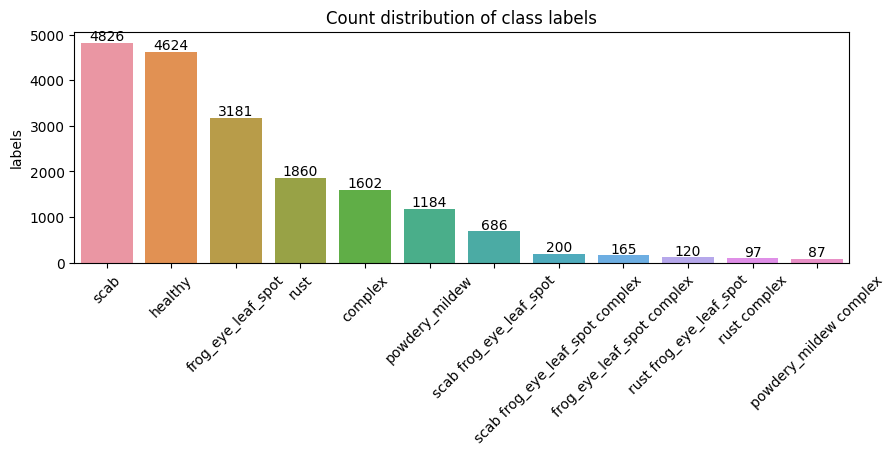

In [7]:
# Plotting count distribution plot of class labels
plt.figure(figsize=(10, 3))
labels = sns.barplot(x=train_data.labels.value_counts().index,y=train_data.labels.value_counts())

for item in labels.get_xticklabels():
    item.set_rotation(45)
    
for i, v in enumerate(train_data.labels.value_counts()):
    labels.text(i, v + 50, str(v), color='black', ha='center')
plt.title("Count distribution of class labels")
plt.show()

In [8]:
train_data['labels'] = train_data['labels'].apply(lambda string: string.split(' '))

In [9]:
s = list(train_data['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train_data.index)

In [10]:
# Plotting count plot of individual diseases
labels = list(trainx.sum().keys())
label_counts = trainx.sum().values.tolist()

fig = go.Figure()
fig.add_trace(go.Bar(x=labels, y=label_counts))

for i, v in enumerate(label_counts):
    fig.add_annotation(x=labels[i], y=v+50, text=str(v), showarrow=False, font=dict(color='black', size=12))

fig.update_layout(title='Bin Counts', xaxis_title='Labels', yaxis_title='Count', width=1000, height=500)
fig.show()


# Canny edge and bounding box detection

In [11]:
# Reading two of images
image_path_1 = '/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/data/train_images_downscaled/8a0be55d81f4bf0c.jpg'
image_path_2 = '/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/data/train_images_downscaled/8a2d598f2ec436e6.jpg'
chosen_image_1 = cv2.imread(image_path_1)
chosen_image_2 = cv2.imread(image_path_2)

In [12]:
# Canny edge and bounding box detection 
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
                
    # detecting bounding box using canny edge values
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    # Plotting bounding box in red color
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    # Plotting original image, canny edge of the image and the detected bounding box
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

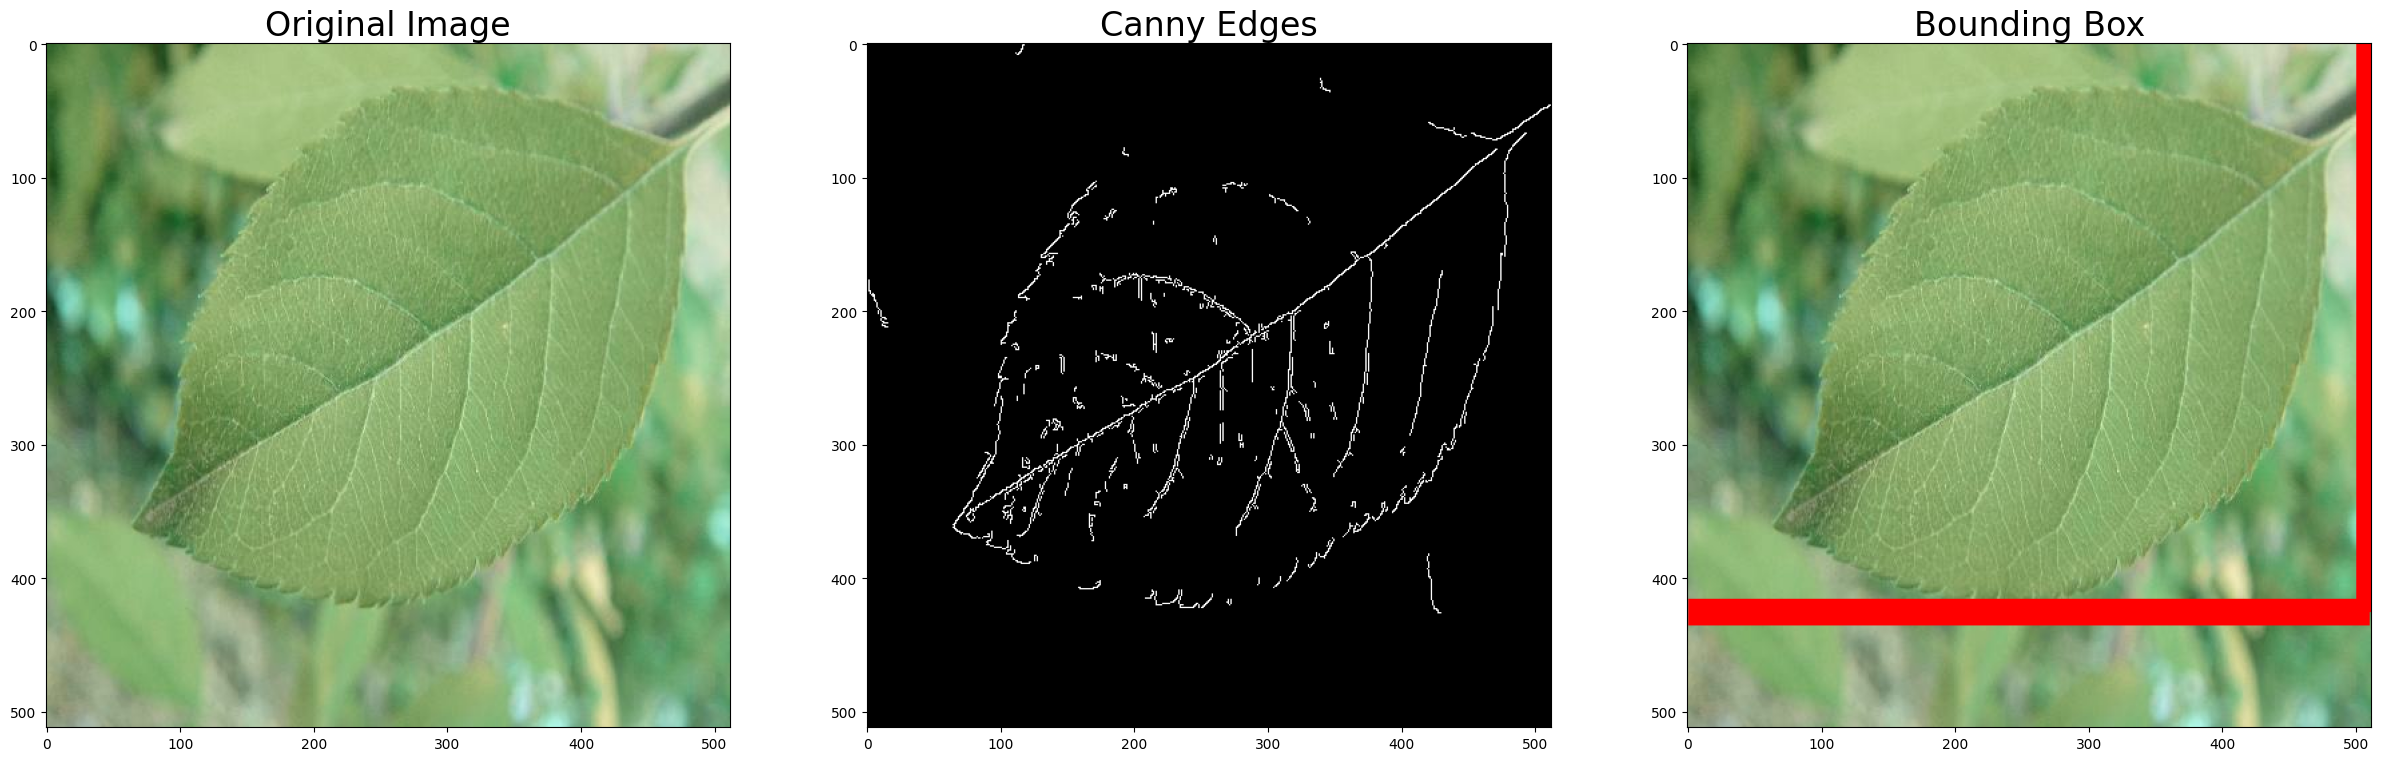

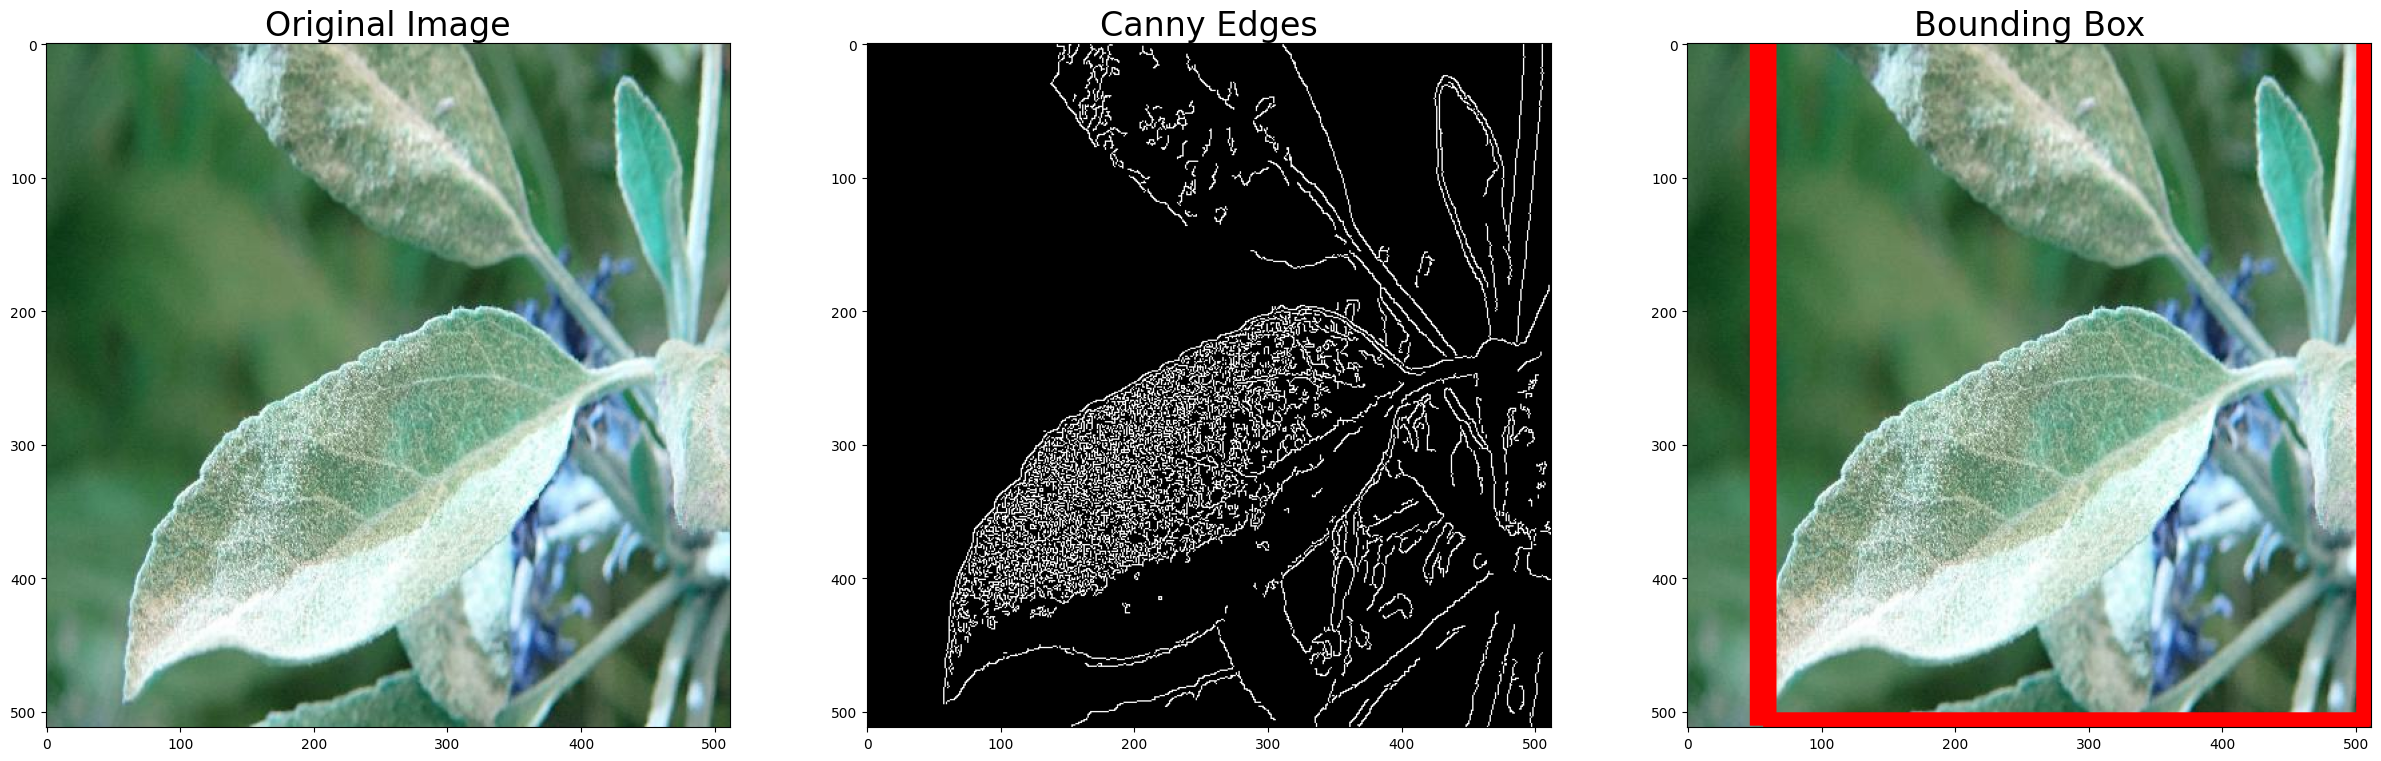

In [13]:
edge_and_cut(chosen_image_1)
edge_and_cut(chosen_image_2)

# Image Augmentations

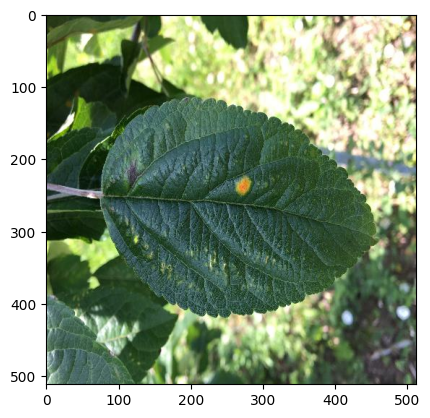

In [14]:
image_path = '/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/data/train_images_downscaled/8aa7d6526ba664b2.jpg'
img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
chosen_image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(chosen_image)
plt.show()

In [15]:
# List of augmentations
albumentation_list = [A.RandomSunFlare(p=1), 
                      A.RandomFog(p=1), 
                      A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), 
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), 
                      A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), 
                      A.VerticalFlip(p=1), 
                      A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
                      A.Cutout(p=1),
                      A.Transpose(p=1), 
                      A.JpegCompression(p=1),
                      A.CoarseDropout(p=1),
                      A.IAAAdditiveGaussianNoise(loc=0, scale=(2.5500000000000003, 12.75), per_channel=False, p=1),
                      A.IAAAffine(scale=1.0, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', p=1),
                      A.IAAAffine(rotate=90., p=1),
                      A.IAAAffine(rotate=180., p=1)]

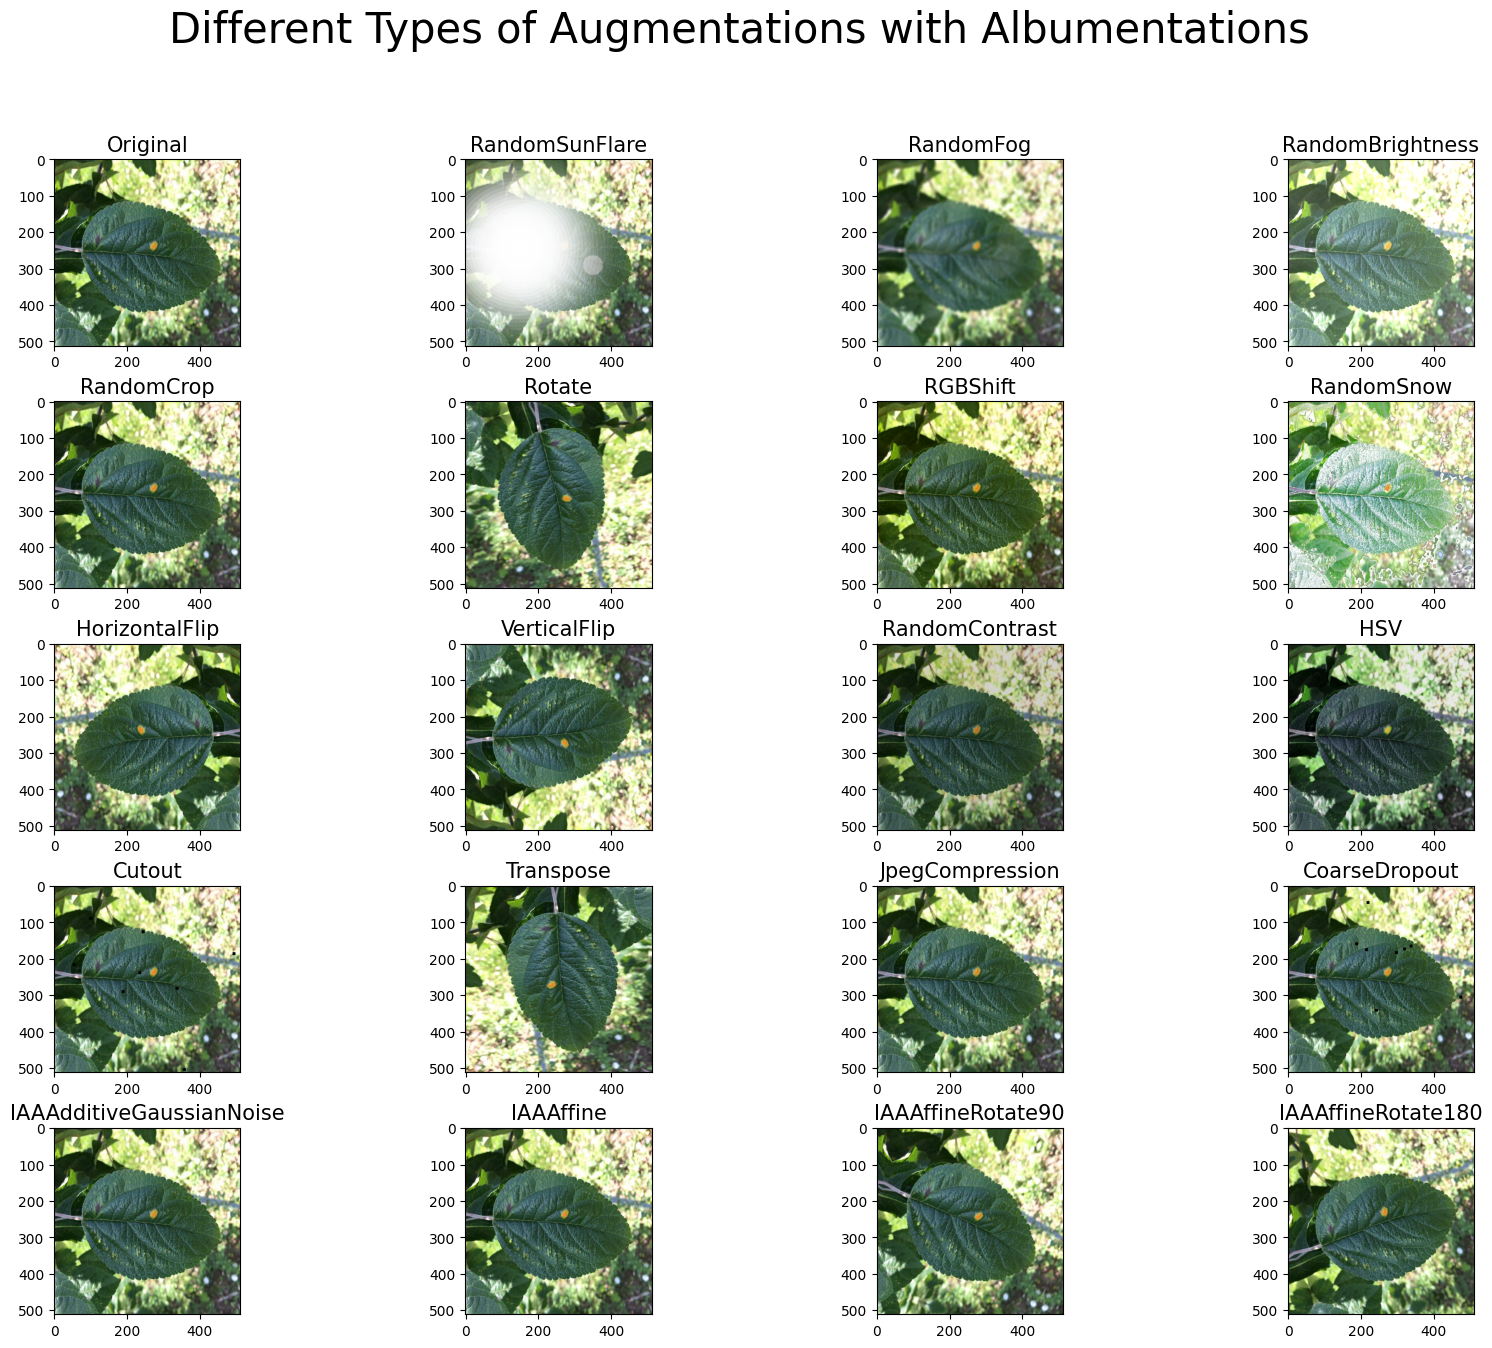

In [16]:
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness",
               "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV",
               "Cutout","Transpose","JpegCompression","CoarseDropout","IAAAdditiveGaussianNoise","IAAAffine","IAAAffineRotate90","IAAAffineRotate180"]

def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=5,  main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_multiple_img(img_matrix_list, titles_list, ncols = 4,main_title="Different Types of Augmentations with Albumentations")

In [17]:
torch_trans_list = [transforms.CenterCrop((178, 178)),
                    transforms.Resize(128),
                    transforms.RandomRotation(45),
                    transforms.RandomAffine(35),
                    transforms.RandomCrop(128),
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.RandomPerspective(p=1),
                    transforms.RandomVerticalFlip(p=1)]

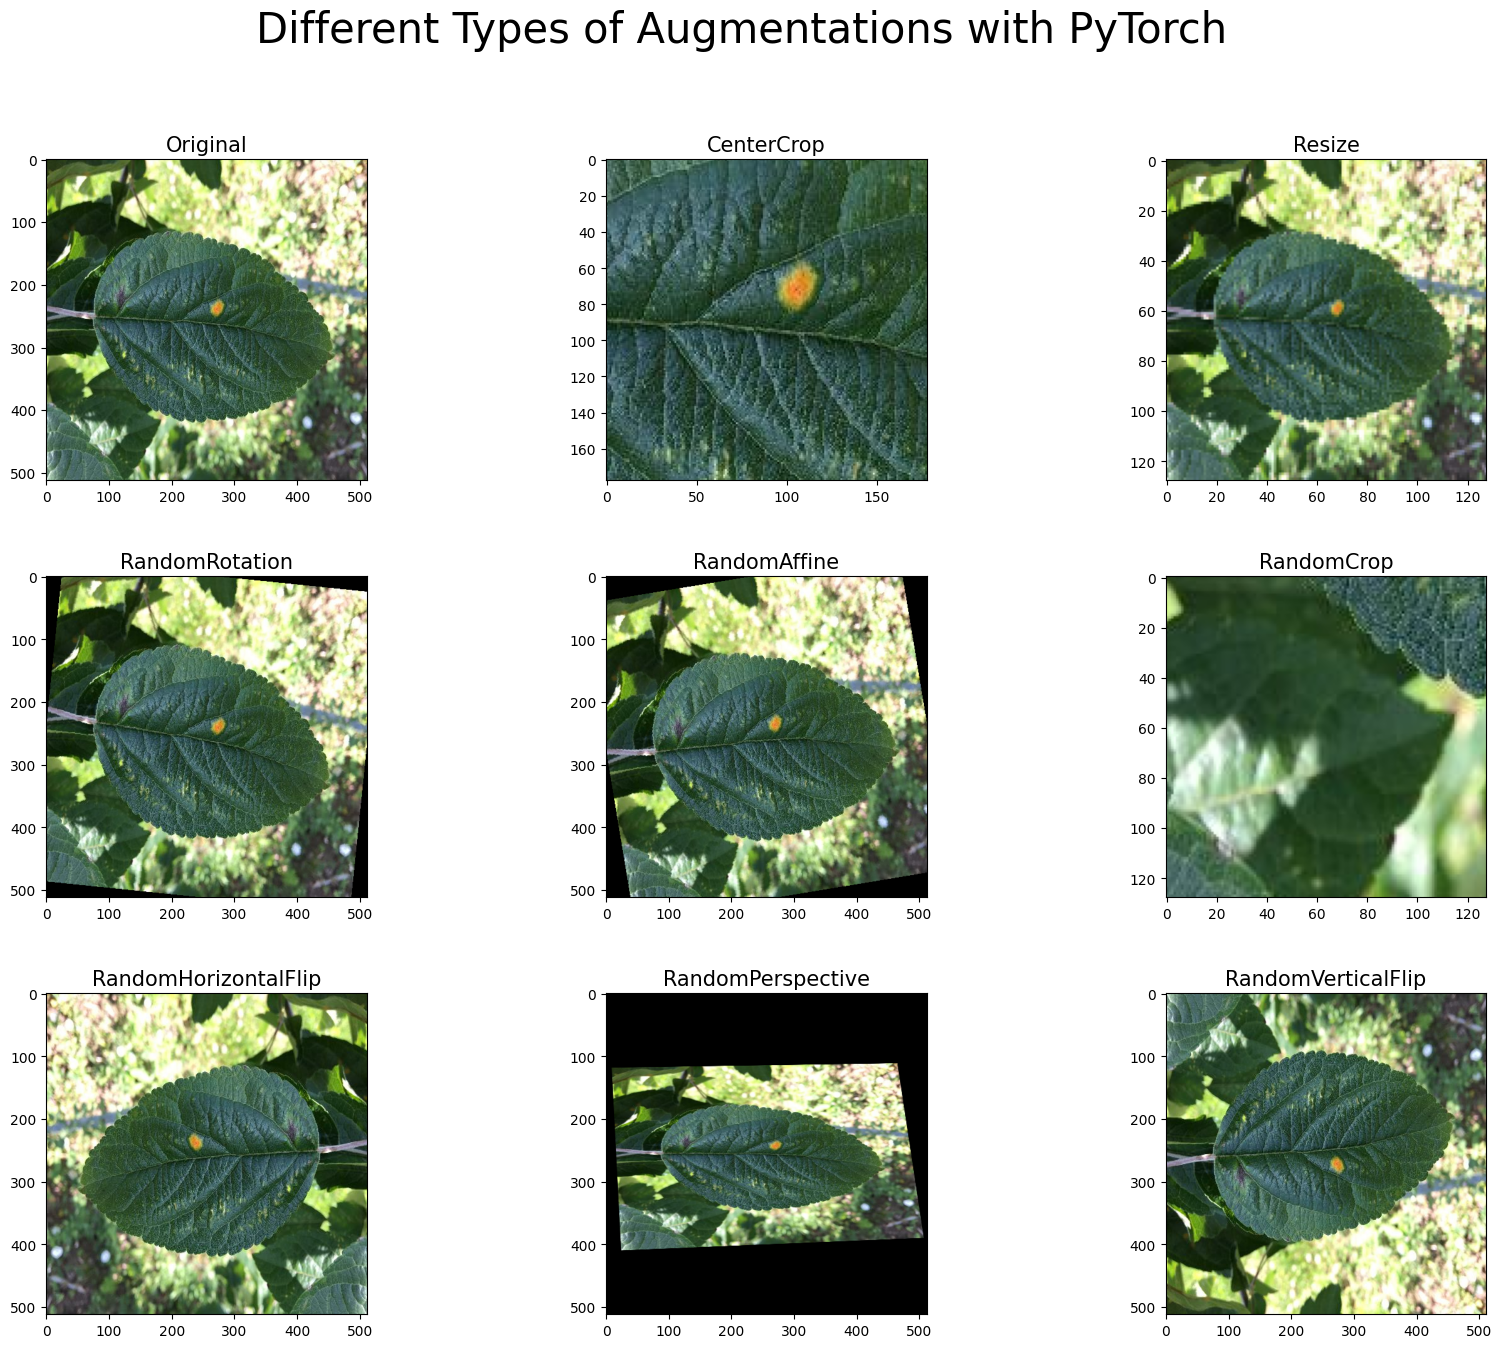

In [18]:
img_matrix_list = []
bboxes_list = []
for aug_type in torch_trans_list:
    # convert to tensor
    chosen_tensor = transforms.Compose([transforms.ToTensor()])(chosen_image)
    chosen_tensor = transforms.Compose([aug_type])(chosen_tensor)
    trans_img = transforms.ToPILImage()(chosen_tensor)
    img_matrix_list.append(trans_img)

img_matrix_list.insert(0, chosen_image)    

titles_list = ["Original","CenterCrop","Resize","RandomRotation","RandomAffine","RandomCrop","RandomHorizontalFlip","RandomPerspective",
               "RandomVerticalFlip"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 3, nrows=3, main_title="Different Types of Augmentations with PyTorch")

# Bee Augmentations

In [19]:
def insect_augmentation(image, n_insects=2, dark_insect=False, p=0.5, insects_folder='/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/data/bee_augmentation'):
    aug_prob = random.random()
    if aug_prob < p:
        height, width, _ = image.shape  # target image width and height
        insects_images = [im for im in os.listdir(insects_folder) if 'bee' in im]
        img_shape = image.shape

        for _ in range(n_insects):
            insect = cv2.cvtColor(cv2.imread(os.path.join(insects_folder, random.choice(insects_images))), cv2.COLOR_BGR2RGB)
            insect = cv2.flip(insect, random.choice([-1, 0, 1]))
            insect = cv2.rotate(insect, random.choice([0, 1, 2]))
            insect = cv2.resize(insect, (width, height))

            h_height, h_width, _ = insect.shape  # insect image width and height
            roi_ho = random.randint(0, image.shape[0] - insect.shape[0])
            roi_wo = random.randint(0, image.shape[1] - insect.shape[1])
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask 
            img2gray = cv2.cvtColor(insect, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            #mask_inv = cv2.cvtColor(cv2.bitwise_not(mask),cv2.COLOR_BGR2GRAY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of insect in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of insect from insect image.
            if dark_insect:
                img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
                insect_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            else:
                insect_fg = cv2.bitwise_and(insect, insect, mask=mask)

            # Put insect in ROI and modify the target image
            dst = cv2.add(img_bg, insect_fg, dtype=cv2.CV_64F)

            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

    return image

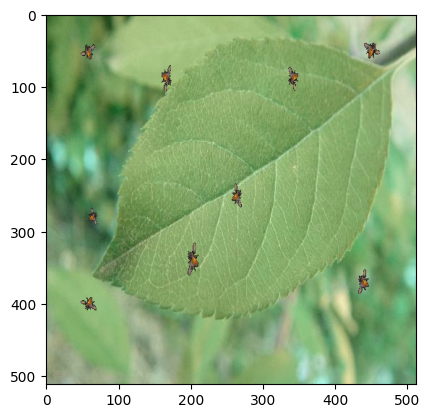

In [20]:
image_path = '/Users/ag/Desktop/Spring 2023/DS5500/Project - Phase 2/data/train_images_downscaled/8a0be55d81f4bf0c.jpg'
chosen_image = cv2.imread(image_path)
aug_image = insect_augmentation(chosen_image, n_insects=2, dark_insect=False, p=1.0)
# plt.imshow(chosen_image)
plt.imshow(aug_image)
plt.show()

In [21]:
# End of the notebook